In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from collections import Counter
from openpyxl import load_workbook
from difflib import get_close_matches
import unicodedata


In [2]:

def fill_model_metrics_into_excel(
    df: pd.DataFrame,
    model_name: str,
    selected_metrics = None,
    excel_path: str = None,
    output_path: str = None,
    sheet_name: str = None,
):
    # Normalize to avoid invisible characters and spaces
    def normalize(text: str) -> str:
        if text is None:
            return ""
        return unicodedata.normalize('NFKC', str(text)).strip().replace('\xa0', ' ')

    # Default to MSE and WAPE if not specified
    if selected_metrics is None:
        selected_metrics = ["MSE", "WAPE"]
    else:
        selected_metrics = [m.upper() for m in selected_metrics]

    # Extract pred_len
    pred_len_values = df["pred_len"].unique()
    if len(pred_len_values) != 1:
        raise ValueError(f"Expected a single pred_len, got: {pred_len_values}")
    pred_len = int(pred_len_values[0])

    # Load workbook and worksheet
    wb = load_workbook(excel_path)
    if sheet_name:
        if sheet_name not in wb.sheetnames:
            raise ValueError(f"Sheet '{sheet_name}' not found in workbook. Available: {wb.sheetnames}")
        ws = wb[sheet_name]
    else:
        ws = wb.active

    # Map model and metric columns
    col_map = {}
    target = normalize(model_name)

    print(f"🔎 Looking for model: {repr(target)}")
    for col in range(3, ws.max_column + 1):
        model_cell = ws.cell(row=1, column=col).value
        model_clean = normalize(model_cell)
        if model_clean != target:
            continue

        metric_name = ws.cell(row=2, column=col).value
        if not metric_name:
            continue

        metric_name = normalize(metric_name).upper()
        print(f"  Col {col}: model={repr(model_clean)} | metric={metric_name}")

        if metric_name in selected_metrics:
            col_map[metric_name] = col

    if not col_map:
        raise ValueError(
            f"No matching columns found for model '{model_name}' and metrics {selected_metrics}"
        )

    # Function to find or append target row
    def find_or_insert_row(group: str, pred_len: int):
        for row in range(3, ws.max_row + 1):
            g = ws.cell(row=row, column=1).value
            p = ws.cell(row=row, column=2).value
            try:
                if g == group and int(p) == int(pred_len):
                    return row
            except:
                continue
        # Not found: insert
        new_row = ws.max_row + 1
        ws.cell(row=new_row, column=1, value=group)
        ws.cell(row=new_row, column=2, value=pred_len)
        return new_row

    # Fill values
    for _, row_data in df.iterrows():
        group = row_data["group"]
        row_idx = find_or_insert_row(group, pred_len)
        for metric in selected_metrics:
            col_idx = col_map.get(metric)
            if col_idx is None:
                continue
            val = (
                row_data.get(metric.lower()) or
                row_data.get(metric.upper()) or
                row_data.get(metric)
            )
            if pd.notna(val):
                ws.cell(row=row_idx, column=col_idx, value=float(val))

    save_path = output_path or excel_path
    wb.save(save_path)
    print(f"✅ Filled '{model_name}' (pred_len={pred_len}) into: {save_path}, sheet: {ws.title}")


In [3]:

def show_results(root_dir):
    summary_results = []
    total_json_count = 0
    all_model_paths = []

    # === Traverse and summarize ===
    for group_dir in sorted(root_dir.iterdir()):
        if not group_dir.is_dir():
            continue

        metrics_list = []

        for subdir in group_dir.iterdir():
            if not subdir.is_dir():
                continue

            json_file = subdir / "results.json"
            if json_file.exists():
                total_json_count += 1
                with open(json_file, "r") as f:
                    data = json.load(f)
                    data["group"] = group_dir.name
                    metrics_list.append(data)
                    all_model_paths.append(data.get("model_path", "unknown"))

        if metrics_list:
            df = pd.DataFrame(metrics_list)
            df_mean = df.drop(columns=["dataset", "freq", "model_path"]).mean(numeric_only=True)
            df_mean["group"] = group_dir.name
            summary_results.append(df_mean)

    # === Combine summaries ===
    summary_df = pd.DataFrame(summary_results)
    summary_df.sort_values("group", inplace=True)

    # === Display summary table ===
    print("\n📊 Summary of Mean Metrics per Dataset Group:")
    display(summary_df)

    # === Compute overall global mean across all groups ===
    global_means = summary_df.drop(columns=["group"]).mean(numeric_only=True)
    print("\n📌 Global Mean Across All Groups:")
    print(global_means.round(4))

    # === Determine model name to display in title ===
    model_name = Counter(all_model_paths).most_common(1)[0][0] if all_model_paths else "Unknown Model"

    # === Visualization ===
    plt.figure(figsize=(12, 6))
    for metric in ["mse", "mae", "smape", "wape", "nrmse"]:
        if metric in summary_df.columns:
            plt.plot(summary_df["group"], summary_df[metric], marker='o', label=metric)

    plt.xticks(rotation=45)
    plt.xlabel("Dataset Group")
    plt.ylabel("Metric Value")
    plt.title(f"Average Forecasting Metrics by Dataset Group\nModel: {model_name} pred len: {summary_df['pred_len'][0]} context len: {summary_df['context_len'][0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Total json count ===
    print(f"\n🔢 Total number of results.json files found: {total_json_count}")

    return summary_df

In [4]:
excel_file_path = r"C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx"
wb = load_workbook(excel_file_path)
ws = wb.active
# Parse all model name columns
model_col_map = {}
for col in range(3, ws.max_column + 1, 1):
    model = ws.cell(row=1, column=col).value
    if model is None:
        continue
    model = model.strip()
    model_col_map[model] = {
    }

print("Available models in Excel headers:", list(model_col_map.keys()))

def print_excel_sheet_contents(excel_path, sheet_name=None):
    wb = load_workbook(excel_path, data_only=True)
    ws = wb[sheet_name] if sheet_name else wb.active

    print("=== Excel Sheet Content ===")
    for row in ws.iter_rows(values_only=True):
        print(row)

#print_excel_sheet_contents(excel_file_path)


Available models in Excel headers: ['TimesFM 200M', 'TimesFM 500M', 'Chronos small', 'Chronos Medium', 'Chronos Large', 'TimesMOE Large', 'FTFM v4 lowq (mean)', 'FTFM v4 (medium5)', 'FTFM v4 (mean)', 'FTFM v3t  (median5)', 'FTFM v3t DDP  (median5)']


## Work Section


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.306698,0.380818,0.238696,0.317997,0.696533,3653.333333,2840.513428,2.910954,20.0,128.0,crypto10_1d
1,0.026006,0.226241,0.099422,0.114253,0.185372,20880.000000,18160.557617,14.415530,20.0,128.0,crypto10_1h
2,0.049619,0.264604,0.124838,0.149711,0.267086,8853.333333,7392.073242,6.257392,20.0,128.0,crypto10_1m
3,0.112654,0.332766,0.202327,0.226520,0.367477,6920.000000,6179.074707,4.730810,20.0,128.0,forex_datasets_1d
4,0.041968,0.261097,0.124648,0.147652,0.236065,20693.333333,17704.054688,14.914697,20.0,128.0,forex_datasets_1h
5,0.108403,0.327488,0.182215,0.210468,0.359945,12160.000000,10519.006510,9.194974,20.0,128.0,forex_datasets_1m
6,0.873817,0.849243,0.570297,0.743359,1.191053,2000.000000,1563.865031,1.493857,20.0,128.0,forex_datasets_1wk
7,0.168540,0.473096,0.206826,0.275306,0.541821,7240.000000,5461.366089,4.774471,20.0,128.0,futures_datasets_1d
8,0.046070,0.238226,0.121479,0.137456,0.242869,16160.000000,14281.685547,11.927652,20.0,128.0,futures_datasets_1h
9,0.240037,0.389825,0.239044,0.287559,0.471192,9120.000000,7832.895752,6.190209,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


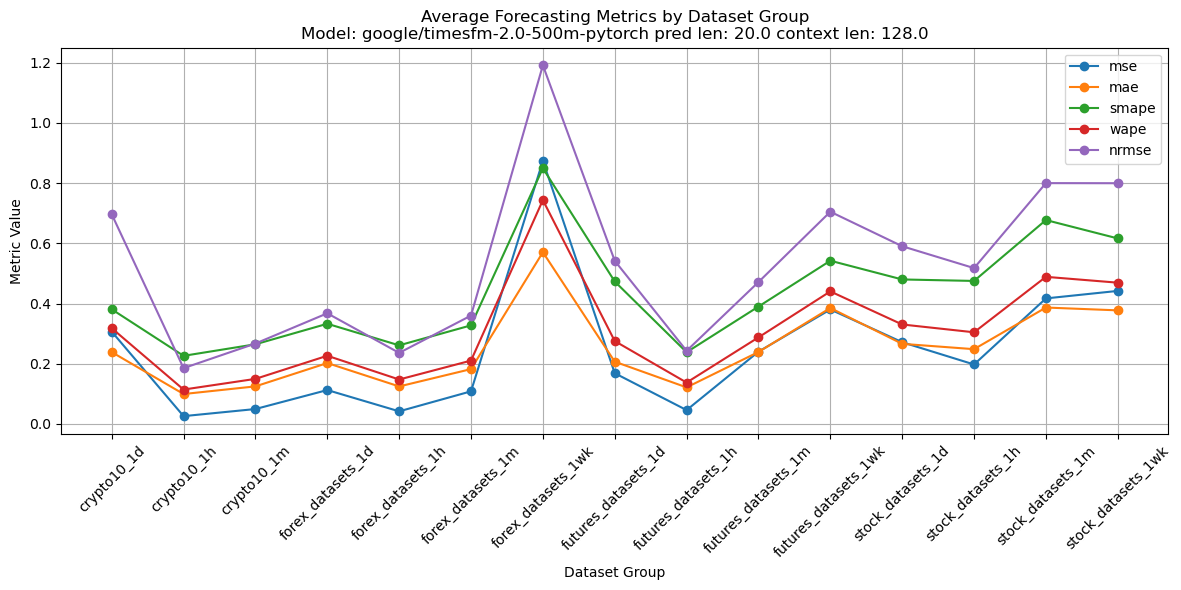


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MSE
✅ Filled 'TimesFM 500M' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.422928,0.429267,0.291890,0.385835,0.824827,3680.000000,2867.131429,1.327957,30.0,128.0,crypto10_1d
1,0.036966,0.268403,0.119624,0.137473,0.220985,20880.000000,18160.559570,6.885046,30.0,128.0,crypto10_1h
2,0.075099,0.325628,0.153516,0.185032,0.330067,8800.000000,7310.747884,3.009890,30.0,128.0,crypto10_1m
3,0.165569,0.381955,0.245213,0.274477,0.444683,6900.000000,6164.434570,2.344885,30.0,128.0,forex_datasets_1d
4,0.064356,0.309693,0.155408,0.185032,0.292967,20640.000000,17603.581380,6.738590,30.0,128.0,forex_datasets_1h
5,0.162479,0.393365,0.229059,0.264851,0.444750,12120.000000,10474.398112,3.985664,30.0,128.0,forex_datasets_1m
6,0.977598,0.887668,0.625461,0.806173,1.267911,2040.000000,1600.562541,0.836473,30.0,128.0,forex_datasets_1wk
7,0.263044,0.552795,0.265755,0.354764,0.683320,7200.000000,5408.967285,2.390527,30.0,128.0,futures_datasets_1d
8,0.070561,0.304796,0.158508,0.179106,0.300153,16080.000000,14230.698242,5.630979,30.0,128.0,futures_datasets_1h
9,0.283871,0.444595,0.280405,0.336548,0.537450,9080.000000,7780.715047,2.968761,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


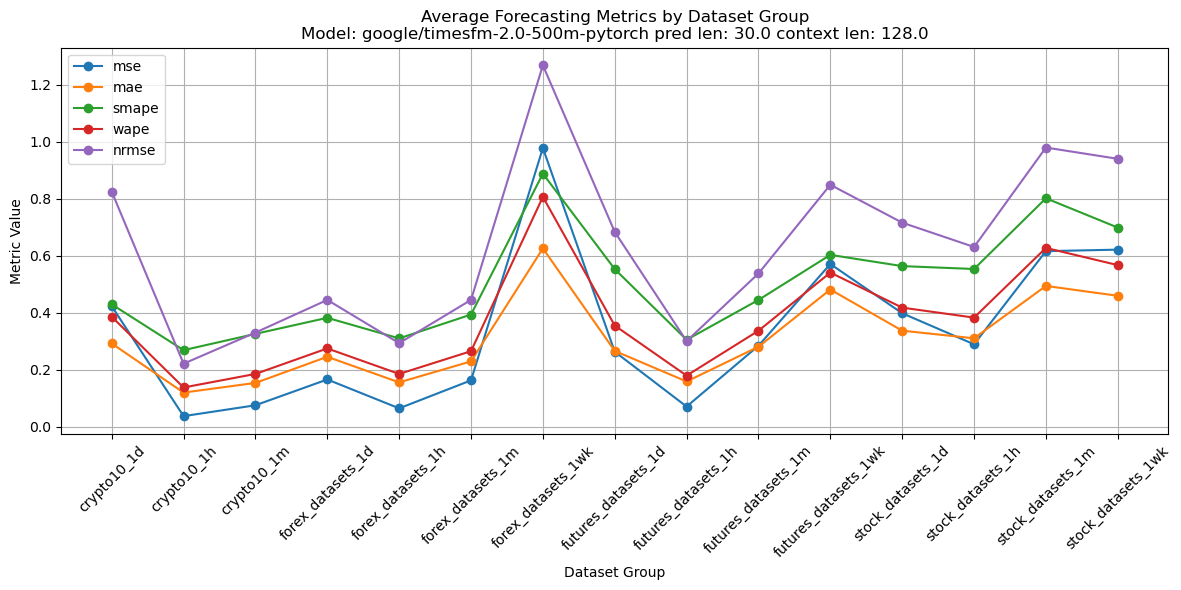


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MSE
✅ Filled 'TimesFM 500M' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.795929,0.618369,0.459739,0.622929,1.159239,3600.000000,2775.409180,0.902629,60.0,128.0,crypto10_1d
1,0.077281,0.361350,0.178267,0.204883,0.319571,20880.000000,18160.557617,4.704183,60.0,128.0,crypto10_1h
2,0.163141,0.439953,0.239053,0.288016,0.486098,8800.000000,7310.747721,2.275101,60.0,128.0,crypto10_1m
3,0.312607,0.541557,0.356569,0.397854,0.603354,6840.000000,6124.638184,1.674391,60.0,128.0,forex_datasets_1d
4,0.139881,0.411435,0.231190,0.275106,0.428826,20560.000000,17539.440104,4.517032,60.0,128.0,forex_datasets_1h
5,0.319056,0.530786,0.335243,0.388801,0.630204,12000.000000,10344.388346,2.903332,60.0,128.0,forex_datasets_1m
6,1.369664,1.048185,0.764694,0.986656,1.496807,1920.000000,1488.001546,0.498453,60.0,128.0,forex_datasets_1wk
7,0.591408,0.700403,0.401643,0.542692,1.033779,7080.000000,5251.835938,1.655020,60.0,128.0,futures_datasets_1d
8,0.126302,0.384940,0.218827,0.247263,0.401574,16080.000000,14230.702148,3.676298,60.0,128.0,futures_datasets_1h
9,0.390160,0.542360,0.366622,0.436716,0.677906,9000.000000,7713.614176,2.064998,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


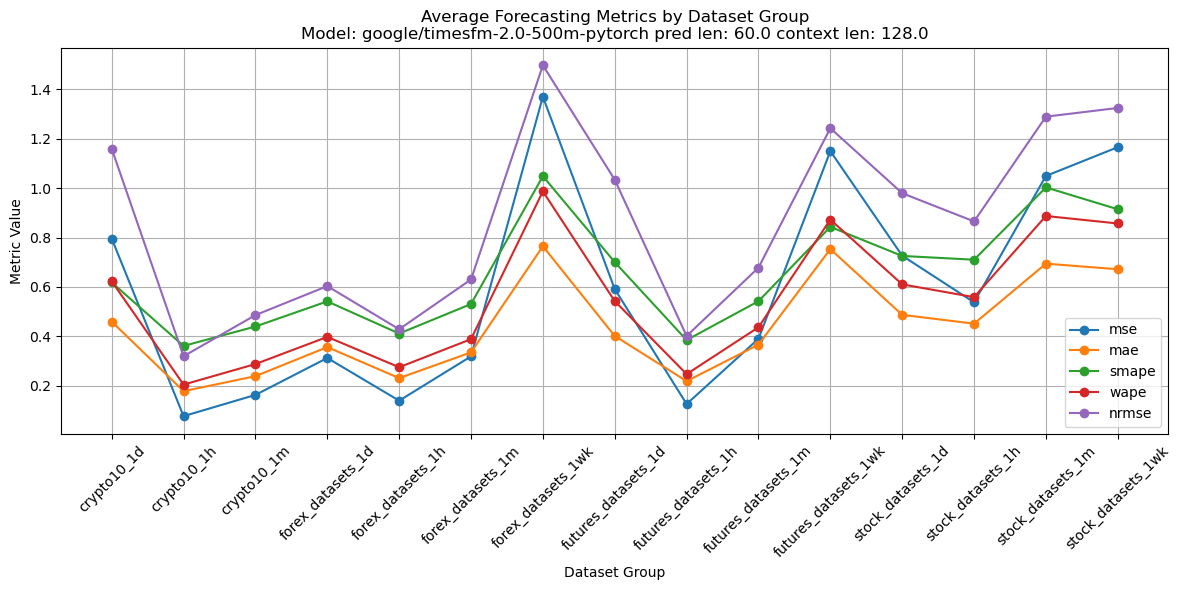


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MSE
✅ Filled 'TimesFM 500M' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.306698,0.380818,0.238696,0.317997,0.696533,3653.333333,2840.513428,2.910954,20.0,128.0,crypto10_1d
1,0.026006,0.226241,0.099422,0.114253,0.185372,20880.000000,18160.557617,14.415530,20.0,128.0,crypto10_1h
2,0.049619,0.264604,0.124838,0.149711,0.267086,8853.333333,7392.073242,6.257392,20.0,128.0,crypto10_1m
3,0.112654,0.332766,0.202327,0.226520,0.367477,6920.000000,6179.074707,4.730810,20.0,128.0,forex_datasets_1d
4,0.041968,0.261097,0.124648,0.147652,0.236065,20693.333333,17704.054688,14.914697,20.0,128.0,forex_datasets_1h
5,0.108403,0.327488,0.182215,0.210468,0.359945,12160.000000,10519.006510,9.194974,20.0,128.0,forex_datasets_1m
6,0.873817,0.849243,0.570297,0.743359,1.191053,2000.000000,1563.865031,1.493857,20.0,128.0,forex_datasets_1wk
7,0.168540,0.473096,0.206826,0.275306,0.541821,7240.000000,5461.366089,4.774471,20.0,128.0,futures_datasets_1d
8,0.046070,0.238226,0.121479,0.137456,0.242869,16160.000000,14281.685547,11.927652,20.0,128.0,futures_datasets_1h
9,0.240037,0.389825,0.239044,0.287559,0.471192,9120.000000,7832.895752,6.190209,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


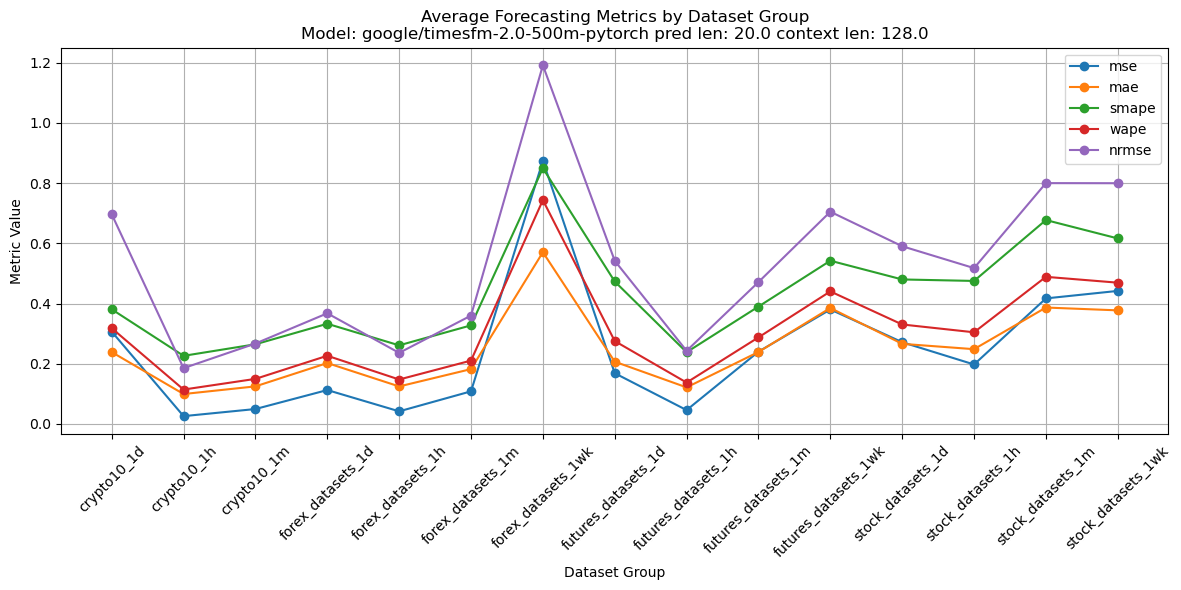


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MAE
✅ Filled 'TimesFM 500M' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.422928,0.429267,0.291890,0.385835,0.824827,3680.000000,2867.131429,1.327957,30.0,128.0,crypto10_1d
1,0.036966,0.268403,0.119624,0.137473,0.220985,20880.000000,18160.559570,6.885046,30.0,128.0,crypto10_1h
2,0.075099,0.325628,0.153516,0.185032,0.330067,8800.000000,7310.747884,3.009890,30.0,128.0,crypto10_1m
3,0.165569,0.381955,0.245213,0.274477,0.444683,6900.000000,6164.434570,2.344885,30.0,128.0,forex_datasets_1d
4,0.064356,0.309693,0.155408,0.185032,0.292967,20640.000000,17603.581380,6.738590,30.0,128.0,forex_datasets_1h
5,0.162479,0.393365,0.229059,0.264851,0.444750,12120.000000,10474.398112,3.985664,30.0,128.0,forex_datasets_1m
6,0.977598,0.887668,0.625461,0.806173,1.267911,2040.000000,1600.562541,0.836473,30.0,128.0,forex_datasets_1wk
7,0.263044,0.552795,0.265755,0.354764,0.683320,7200.000000,5408.967285,2.390527,30.0,128.0,futures_datasets_1d
8,0.070561,0.304796,0.158508,0.179106,0.300153,16080.000000,14230.698242,5.630979,30.0,128.0,futures_datasets_1h
9,0.283871,0.444595,0.280405,0.336548,0.537450,9080.000000,7780.715047,2.968761,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


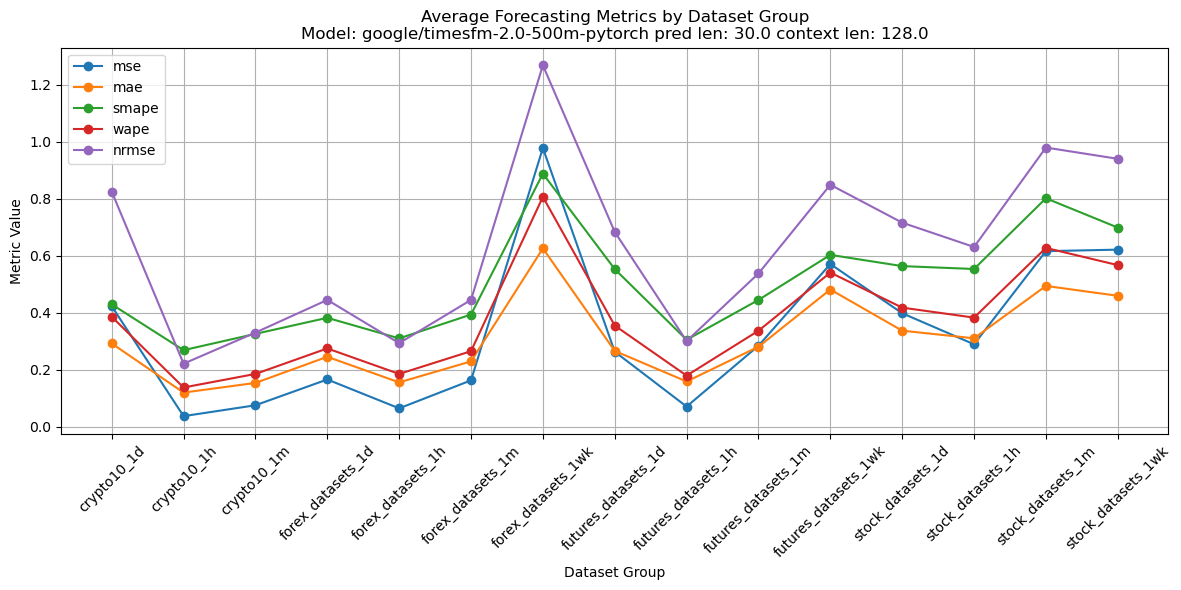


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MAE
✅ Filled 'TimesFM 500M' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.795929,0.618369,0.459739,0.622929,1.159239,3600.000000,2775.409180,0.902629,60.0,128.0,crypto10_1d
1,0.077281,0.361350,0.178267,0.204883,0.319571,20880.000000,18160.557617,4.704183,60.0,128.0,crypto10_1h
2,0.163141,0.439953,0.239053,0.288016,0.486098,8800.000000,7310.747721,2.275101,60.0,128.0,crypto10_1m
3,0.312607,0.541557,0.356569,0.397854,0.603354,6840.000000,6124.638184,1.674391,60.0,128.0,forex_datasets_1d
4,0.139881,0.411435,0.231190,0.275106,0.428826,20560.000000,17539.440104,4.517032,60.0,128.0,forex_datasets_1h
5,0.319056,0.530786,0.335243,0.388801,0.630204,12000.000000,10344.388346,2.903332,60.0,128.0,forex_datasets_1m
6,1.369664,1.048185,0.764694,0.986656,1.496807,1920.000000,1488.001546,0.498453,60.0,128.0,forex_datasets_1wk
7,0.591408,0.700403,0.401643,0.542692,1.033779,7080.000000,5251.835938,1.655020,60.0,128.0,futures_datasets_1d
8,0.126302,0.384940,0.218827,0.247263,0.401574,16080.000000,14230.702148,3.676298,60.0,128.0,futures_datasets_1h
9,0.390160,0.542360,0.366622,0.436716,0.677906,9000.000000,7713.614176,2.064998,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


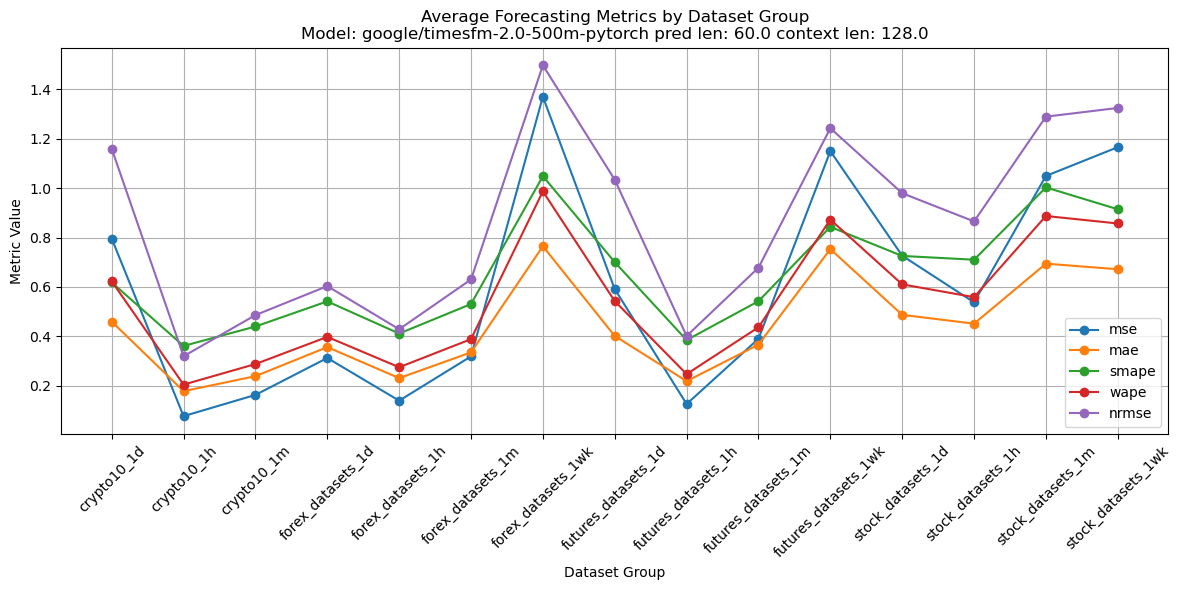


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=MAE
✅ Filled 'TimesFM 500M' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.306698,0.380818,0.238696,0.317997,0.696533,3653.333333,2840.513428,2.910954,20.0,128.0,crypto10_1d
1,0.026006,0.226241,0.099422,0.114253,0.185372,20880.000000,18160.557617,14.415530,20.0,128.0,crypto10_1h
2,0.049619,0.264604,0.124838,0.149711,0.267086,8853.333333,7392.073242,6.257392,20.0,128.0,crypto10_1m
3,0.112654,0.332766,0.202327,0.226520,0.367477,6920.000000,6179.074707,4.730810,20.0,128.0,forex_datasets_1d
4,0.041968,0.261097,0.124648,0.147652,0.236065,20693.333333,17704.054688,14.914697,20.0,128.0,forex_datasets_1h
5,0.108403,0.327488,0.182215,0.210468,0.359945,12160.000000,10519.006510,9.194974,20.0,128.0,forex_datasets_1m
6,0.873817,0.849243,0.570297,0.743359,1.191053,2000.000000,1563.865031,1.493857,20.0,128.0,forex_datasets_1wk
7,0.168540,0.473096,0.206826,0.275306,0.541821,7240.000000,5461.366089,4.774471,20.0,128.0,futures_datasets_1d
8,0.046070,0.238226,0.121479,0.137456,0.242869,16160.000000,14281.685547,11.927652,20.0,128.0,futures_datasets_1h
9,0.240037,0.389825,0.239044,0.287559,0.471192,9120.000000,7832.895752,6.190209,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


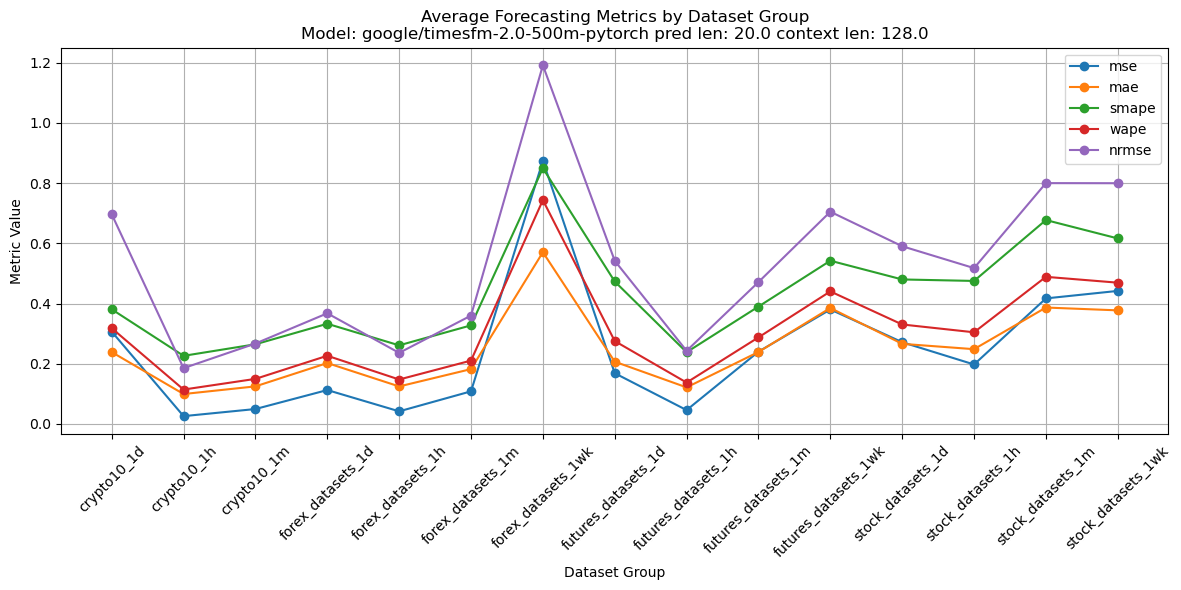


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=SMAPE
✅ Filled 'TimesFM 500M' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.422928,0.429267,0.291890,0.385835,0.824827,3680.000000,2867.131429,1.327957,30.0,128.0,crypto10_1d
1,0.036966,0.268403,0.119624,0.137473,0.220985,20880.000000,18160.559570,6.885046,30.0,128.0,crypto10_1h
2,0.075099,0.325628,0.153516,0.185032,0.330067,8800.000000,7310.747884,3.009890,30.0,128.0,crypto10_1m
3,0.165569,0.381955,0.245213,0.274477,0.444683,6900.000000,6164.434570,2.344885,30.0,128.0,forex_datasets_1d
4,0.064356,0.309693,0.155408,0.185032,0.292967,20640.000000,17603.581380,6.738590,30.0,128.0,forex_datasets_1h
5,0.162479,0.393365,0.229059,0.264851,0.444750,12120.000000,10474.398112,3.985664,30.0,128.0,forex_datasets_1m
6,0.977598,0.887668,0.625461,0.806173,1.267911,2040.000000,1600.562541,0.836473,30.0,128.0,forex_datasets_1wk
7,0.263044,0.552795,0.265755,0.354764,0.683320,7200.000000,5408.967285,2.390527,30.0,128.0,futures_datasets_1d
8,0.070561,0.304796,0.158508,0.179106,0.300153,16080.000000,14230.698242,5.630979,30.0,128.0,futures_datasets_1h
9,0.283871,0.444595,0.280405,0.336548,0.537450,9080.000000,7780.715047,2.968761,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


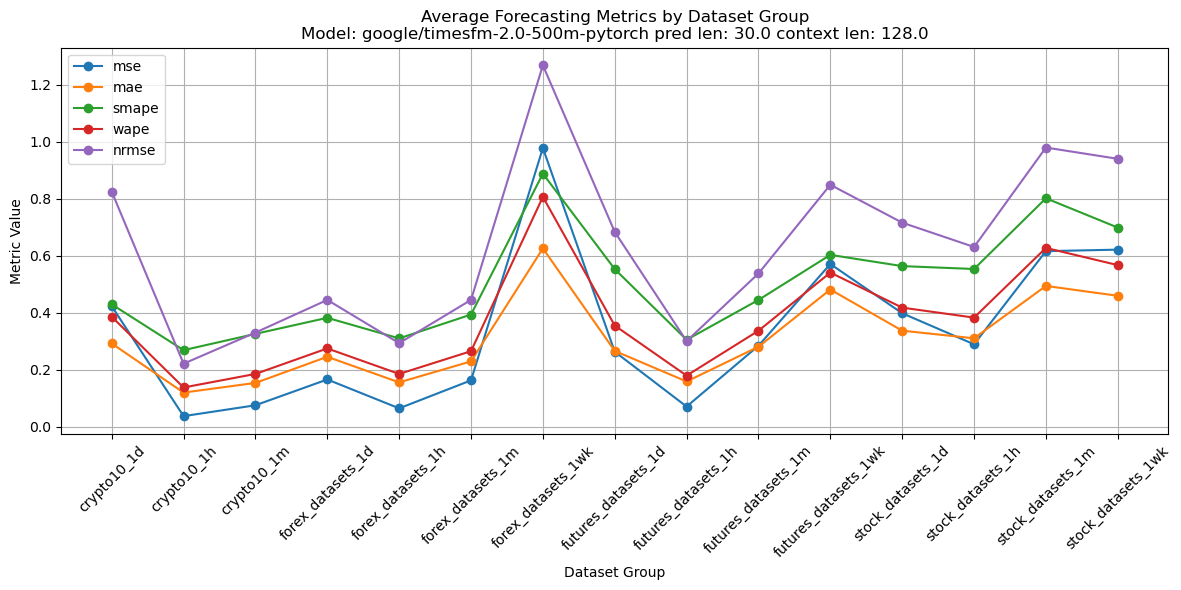


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=SMAPE
✅ Filled 'TimesFM 500M' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.795929,0.618369,0.459739,0.622929,1.159239,3600.000000,2775.409180,0.902629,60.0,128.0,crypto10_1d
1,0.077281,0.361350,0.178267,0.204883,0.319571,20880.000000,18160.557617,4.704183,60.0,128.0,crypto10_1h
2,0.163141,0.439953,0.239053,0.288016,0.486098,8800.000000,7310.747721,2.275101,60.0,128.0,crypto10_1m
3,0.312607,0.541557,0.356569,0.397854,0.603354,6840.000000,6124.638184,1.674391,60.0,128.0,forex_datasets_1d
4,0.139881,0.411435,0.231190,0.275106,0.428826,20560.000000,17539.440104,4.517032,60.0,128.0,forex_datasets_1h
5,0.319056,0.530786,0.335243,0.388801,0.630204,12000.000000,10344.388346,2.903332,60.0,128.0,forex_datasets_1m
6,1.369664,1.048185,0.764694,0.986656,1.496807,1920.000000,1488.001546,0.498453,60.0,128.0,forex_datasets_1wk
7,0.591408,0.700403,0.401643,0.542692,1.033779,7080.000000,5251.835938,1.655020,60.0,128.0,futures_datasets_1d
8,0.126302,0.384940,0.218827,0.247263,0.401574,16080.000000,14230.702148,3.676298,60.0,128.0,futures_datasets_1h
9,0.390160,0.542360,0.366622,0.436716,0.677906,9000.000000,7713.614176,2.064998,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


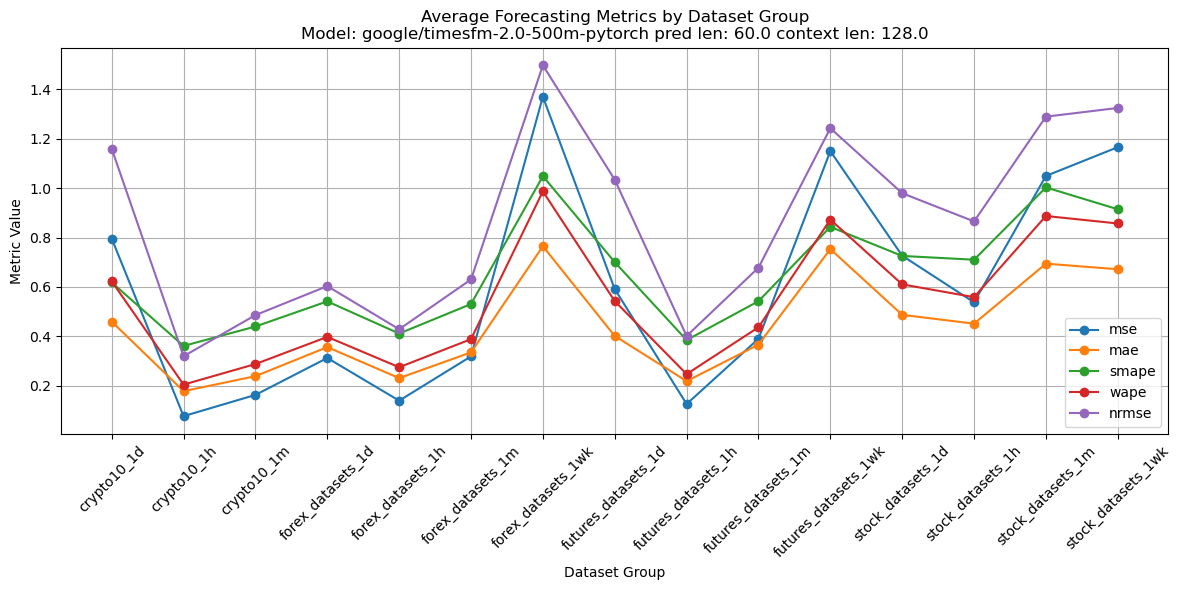


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=SMAPE
✅ Filled 'TimesFM 500M' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.306698,0.380818,0.238696,0.317997,0.696533,3653.333333,2840.513428,2.910954,20.0,128.0,crypto10_1d
1,0.026006,0.226241,0.099422,0.114253,0.185372,20880.000000,18160.557617,14.415530,20.0,128.0,crypto10_1h
2,0.049619,0.264604,0.124838,0.149711,0.267086,8853.333333,7392.073242,6.257392,20.0,128.0,crypto10_1m
3,0.112654,0.332766,0.202327,0.226520,0.367477,6920.000000,6179.074707,4.730810,20.0,128.0,forex_datasets_1d
4,0.041968,0.261097,0.124648,0.147652,0.236065,20693.333333,17704.054688,14.914697,20.0,128.0,forex_datasets_1h
5,0.108403,0.327488,0.182215,0.210468,0.359945,12160.000000,10519.006510,9.194974,20.0,128.0,forex_datasets_1m
6,0.873817,0.849243,0.570297,0.743359,1.191053,2000.000000,1563.865031,1.493857,20.0,128.0,forex_datasets_1wk
7,0.168540,0.473096,0.206826,0.275306,0.541821,7240.000000,5461.366089,4.774471,20.0,128.0,futures_datasets_1d
8,0.046070,0.238226,0.121479,0.137456,0.242869,16160.000000,14281.685547,11.927652,20.0,128.0,futures_datasets_1h
9,0.240037,0.389825,0.239044,0.287559,0.471192,9120.000000,7832.895752,6.190209,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


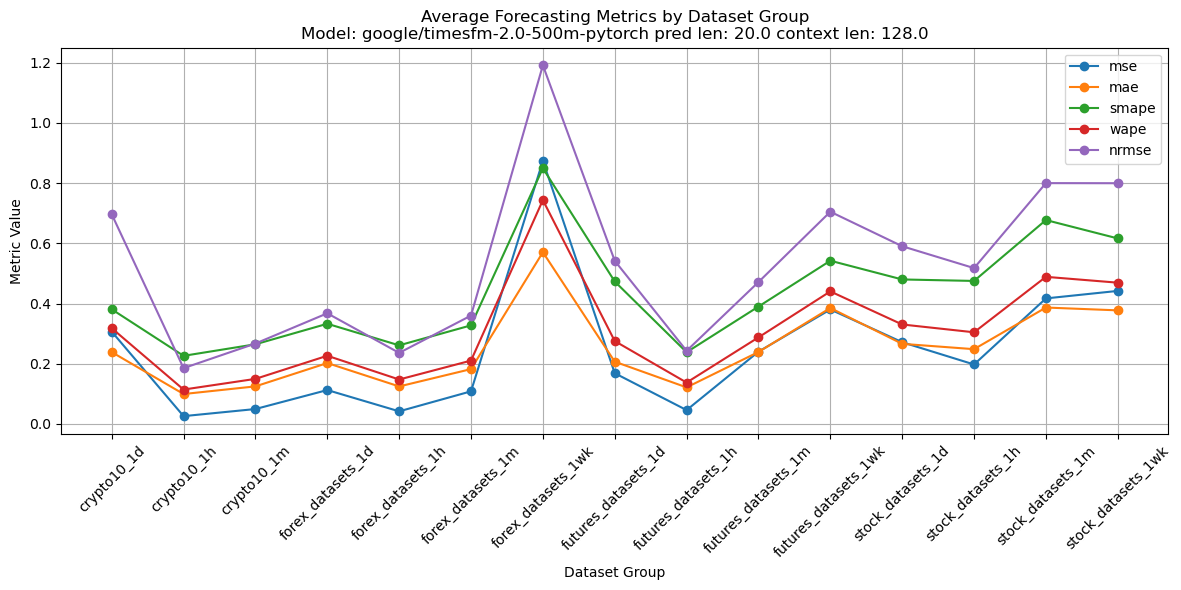


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=WAPE
✅ Filled 'TimesFM 500M' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.422928,0.429267,0.291890,0.385835,0.824827,3680.000000,2867.131429,1.327957,30.0,128.0,crypto10_1d
1,0.036966,0.268403,0.119624,0.137473,0.220985,20880.000000,18160.559570,6.885046,30.0,128.0,crypto10_1h
2,0.075099,0.325628,0.153516,0.185032,0.330067,8800.000000,7310.747884,3.009890,30.0,128.0,crypto10_1m
3,0.165569,0.381955,0.245213,0.274477,0.444683,6900.000000,6164.434570,2.344885,30.0,128.0,forex_datasets_1d
4,0.064356,0.309693,0.155408,0.185032,0.292967,20640.000000,17603.581380,6.738590,30.0,128.0,forex_datasets_1h
5,0.162479,0.393365,0.229059,0.264851,0.444750,12120.000000,10474.398112,3.985664,30.0,128.0,forex_datasets_1m
6,0.977598,0.887668,0.625461,0.806173,1.267911,2040.000000,1600.562541,0.836473,30.0,128.0,forex_datasets_1wk
7,0.263044,0.552795,0.265755,0.354764,0.683320,7200.000000,5408.967285,2.390527,30.0,128.0,futures_datasets_1d
8,0.070561,0.304796,0.158508,0.179106,0.300153,16080.000000,14230.698242,5.630979,30.0,128.0,futures_datasets_1h
9,0.283871,0.444595,0.280405,0.336548,0.537450,9080.000000,7780.715047,2.968761,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


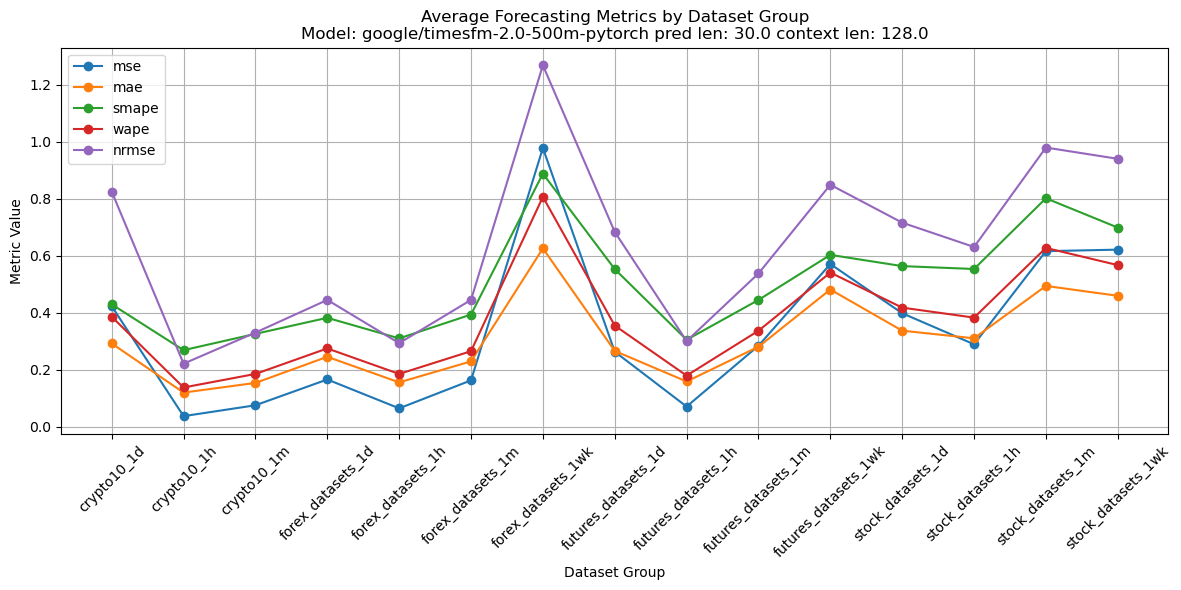


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=WAPE
✅ Filled 'TimesFM 500M' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.795929,0.618369,0.459739,0.622929,1.159239,3600.000000,2775.409180,0.902629,60.0,128.0,crypto10_1d
1,0.077281,0.361350,0.178267,0.204883,0.319571,20880.000000,18160.557617,4.704183,60.0,128.0,crypto10_1h
2,0.163141,0.439953,0.239053,0.288016,0.486098,8800.000000,7310.747721,2.275101,60.0,128.0,crypto10_1m
3,0.312607,0.541557,0.356569,0.397854,0.603354,6840.000000,6124.638184,1.674391,60.0,128.0,forex_datasets_1d
4,0.139881,0.411435,0.231190,0.275106,0.428826,20560.000000,17539.440104,4.517032,60.0,128.0,forex_datasets_1h
5,0.319056,0.530786,0.335243,0.388801,0.630204,12000.000000,10344.388346,2.903332,60.0,128.0,forex_datasets_1m
6,1.369664,1.048185,0.764694,0.986656,1.496807,1920.000000,1488.001546,0.498453,60.0,128.0,forex_datasets_1wk
7,0.591408,0.700403,0.401643,0.542692,1.033779,7080.000000,5251.835938,1.655020,60.0,128.0,futures_datasets_1d
8,0.126302,0.384940,0.218827,0.247263,0.401574,16080.000000,14230.702148,3.676298,60.0,128.0,futures_datasets_1h
9,0.390160,0.542360,0.366622,0.436716,0.677906,9000.000000,7713.614176,2.064998,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


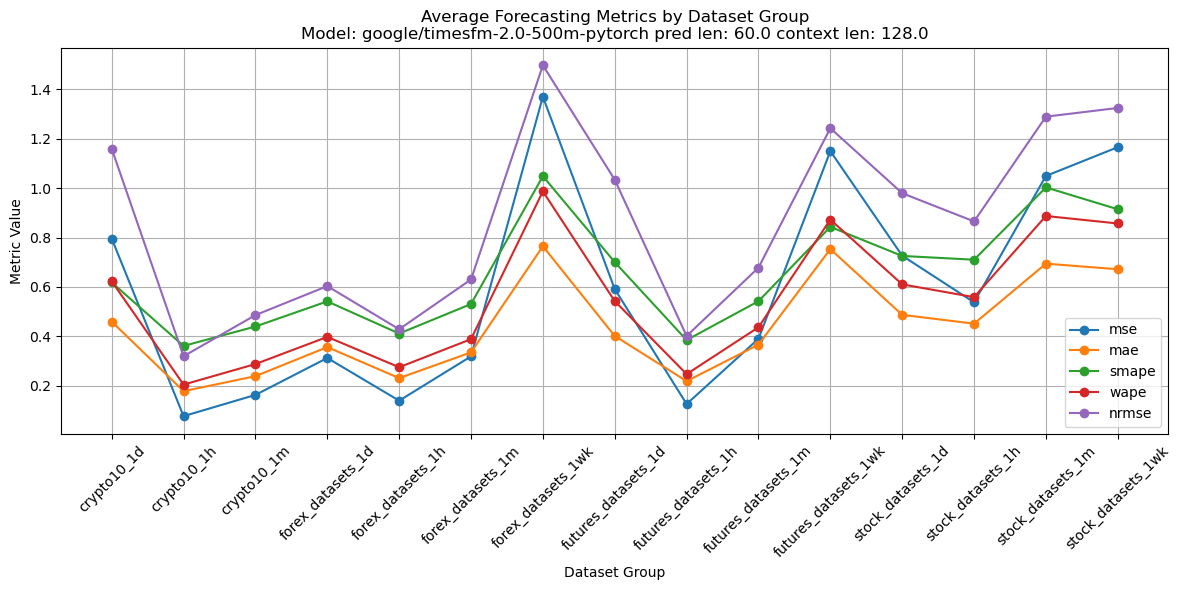


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=WAPE
✅ Filled 'TimesFM 500M' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.306698,0.380818,0.238696,0.317997,0.696533,3653.333333,2840.513428,2.910954,20.0,128.0,crypto10_1d
1,0.026006,0.226241,0.099422,0.114253,0.185372,20880.000000,18160.557617,14.415530,20.0,128.0,crypto10_1h
2,0.049619,0.264604,0.124838,0.149711,0.267086,8853.333333,7392.073242,6.257392,20.0,128.0,crypto10_1m
3,0.112654,0.332766,0.202327,0.226520,0.367477,6920.000000,6179.074707,4.730810,20.0,128.0,forex_datasets_1d
4,0.041968,0.261097,0.124648,0.147652,0.236065,20693.333333,17704.054688,14.914697,20.0,128.0,forex_datasets_1h
5,0.108403,0.327488,0.182215,0.210468,0.359945,12160.000000,10519.006510,9.194974,20.0,128.0,forex_datasets_1m
6,0.873817,0.849243,0.570297,0.743359,1.191053,2000.000000,1563.865031,1.493857,20.0,128.0,forex_datasets_1wk
7,0.168540,0.473096,0.206826,0.275306,0.541821,7240.000000,5461.366089,4.774471,20.0,128.0,futures_datasets_1d
8,0.046070,0.238226,0.121479,0.137456,0.242869,16160.000000,14281.685547,11.927652,20.0,128.0,futures_datasets_1h
9,0.240037,0.389825,0.239044,0.287559,0.471192,9120.000000,7832.895752,6.190209,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2455
smape              0.4356
mae                0.2516
wape               0.3095
nrmse              0.5314
num_elements    8500.5135
abs_sum         7219.2052
total_time         6.0177
pred_len          20.0000
context_len      128.0000
dtype: float64


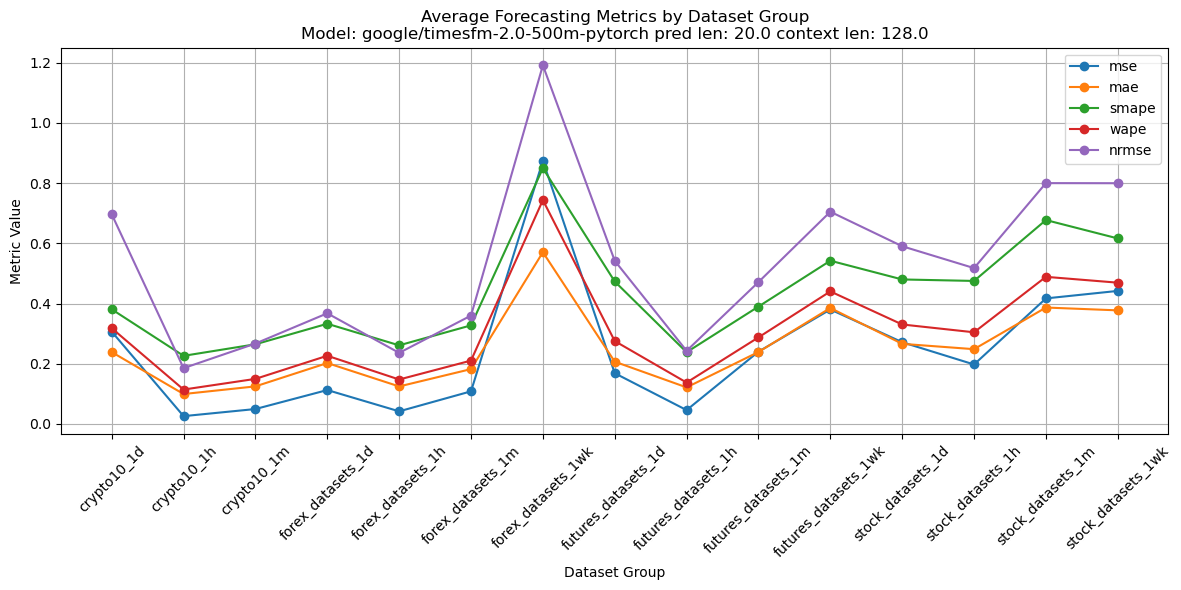


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=NRMSE
✅ Filled 'TimesFM 500M' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.422928,0.429267,0.291890,0.385835,0.824827,3680.000000,2867.131429,1.327957,30.0,128.0,crypto10_1d
1,0.036966,0.268403,0.119624,0.137473,0.220985,20880.000000,18160.559570,6.885046,30.0,128.0,crypto10_1h
2,0.075099,0.325628,0.153516,0.185032,0.330067,8800.000000,7310.747884,3.009890,30.0,128.0,crypto10_1m
3,0.165569,0.381955,0.245213,0.274477,0.444683,6900.000000,6164.434570,2.344885,30.0,128.0,forex_datasets_1d
4,0.064356,0.309693,0.155408,0.185032,0.292967,20640.000000,17603.581380,6.738590,30.0,128.0,forex_datasets_1h
5,0.162479,0.393365,0.229059,0.264851,0.444750,12120.000000,10474.398112,3.985664,30.0,128.0,forex_datasets_1m
6,0.977598,0.887668,0.625461,0.806173,1.267911,2040.000000,1600.562541,0.836473,30.0,128.0,forex_datasets_1wk
7,0.263044,0.552795,0.265755,0.354764,0.683320,7200.000000,5408.967285,2.390527,30.0,128.0,futures_datasets_1d
8,0.070561,0.304796,0.158508,0.179106,0.300153,16080.000000,14230.698242,5.630979,30.0,128.0,futures_datasets_1h
9,0.283871,0.444595,0.280405,0.336548,0.537450,9080.000000,7780.715047,2.968761,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.3345
smape              0.5011
mae                0.3071
wape               0.3763
nrmse              0.6307
num_elements    8482.6778
abs_sum         7197.0067
total_time         2.8894
pred_len          30.0000
context_len      128.0000
dtype: float64


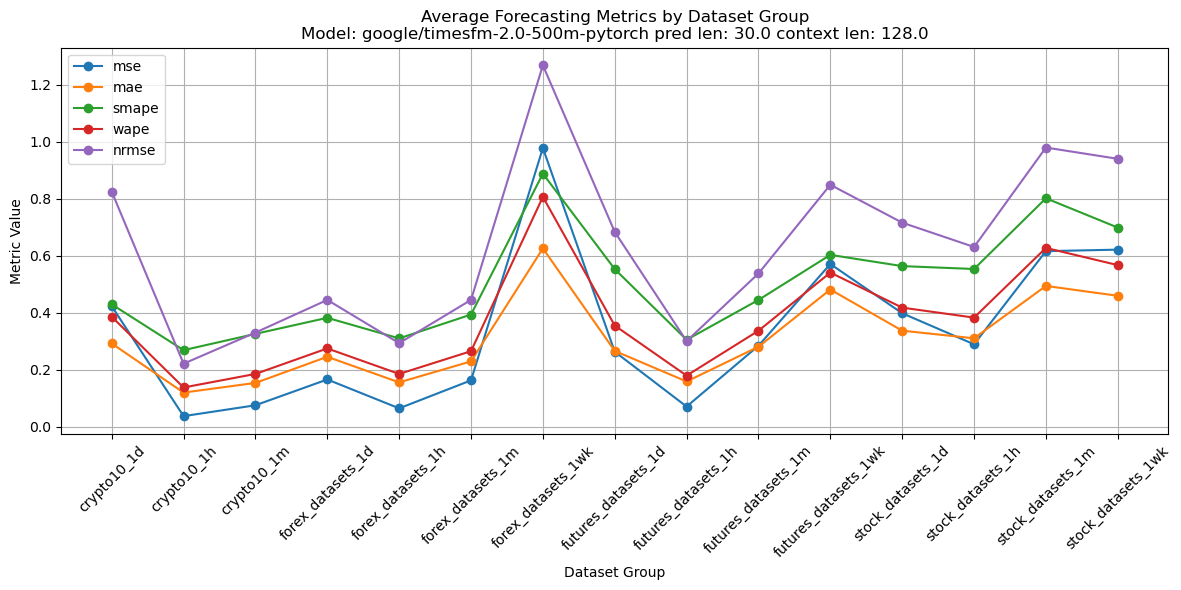


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=NRMSE
✅ Filled 'TimesFM 500M' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.795929,0.618369,0.459739,0.622929,1.159239,3600.000000,2775.409180,0.902629,60.0,128.0,crypto10_1d
1,0.077281,0.361350,0.178267,0.204883,0.319571,20880.000000,18160.557617,4.704183,60.0,128.0,crypto10_1h
2,0.163141,0.439953,0.239053,0.288016,0.486098,8800.000000,7310.747721,2.275101,60.0,128.0,crypto10_1m
3,0.312607,0.541557,0.356569,0.397854,0.603354,6840.000000,6124.638184,1.674391,60.0,128.0,forex_datasets_1d
4,0.139881,0.411435,0.231190,0.275106,0.428826,20560.000000,17539.440104,4.517032,60.0,128.0,forex_datasets_1h
5,0.319056,0.530786,0.335243,0.388801,0.630204,12000.000000,10344.388346,2.903332,60.0,128.0,forex_datasets_1m
6,1.369664,1.048185,0.764694,0.986656,1.496807,1920.000000,1488.001546,0.498453,60.0,128.0,forex_datasets_1wk
7,0.591408,0.700403,0.401643,0.542692,1.033779,7080.000000,5251.835938,1.655020,60.0,128.0,futures_datasets_1d
8,0.126302,0.384940,0.218827,0.247263,0.401574,16080.000000,14230.702148,3.676298,60.0,128.0,futures_datasets_1h
9,0.390160,0.542360,0.366622,0.436716,0.677906,9000.000000,7713.614176,2.064998,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.5942
smape              0.6517
mae                0.4406
wape               0.5451
nrmse              0.8625
num_elements    8412.9351
abs_sum         7119.8149
total_time         1.9639
pred_len          60.0000
context_len      128.0000
dtype: float64


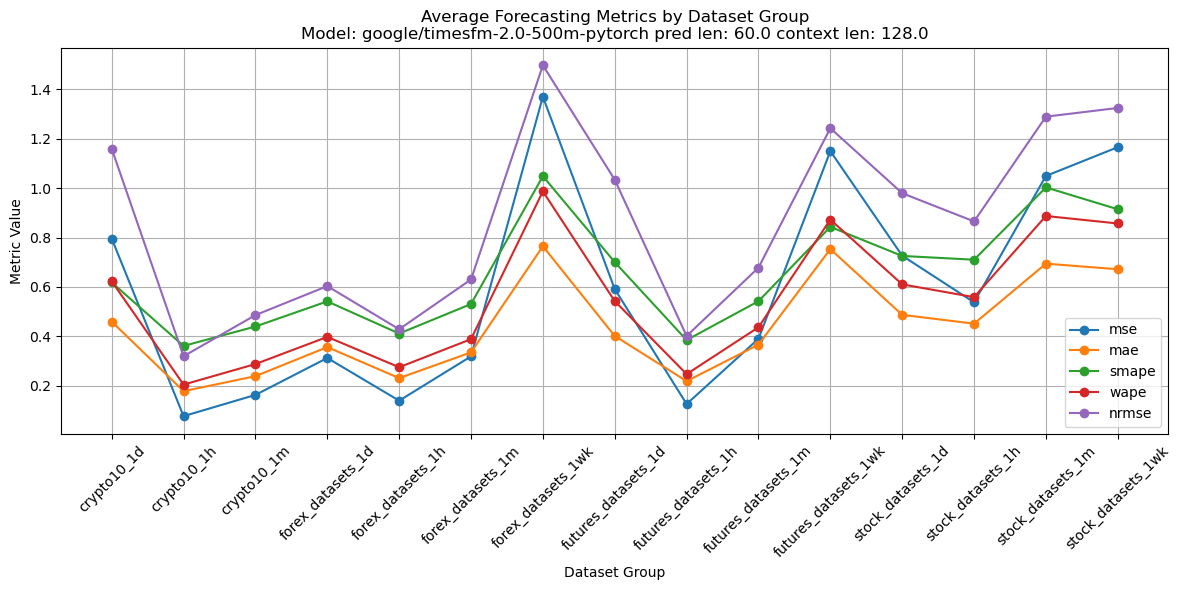


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesFM 500M'
  Col 4: model='TimesFM 500M' | metric=NRMSE
✅ Filled 'TimesFM 500M' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse


In [10]:
metrics = ["MSE", "MAE", "SMAPE", "WAPE", "NRMSE"]
result_excel_path = r"results\tsfm\tsfm_500m_of1"
L = [20, 30, 60]  
target_model = "TimesFM 500M"

for metric in metrics:
    for i in L:
        result_p = Path(r"{}\h{}".format(result_excel_path, str(i)))
        df = show_results(result_p)

        #data load into excel
        fill_model_metrics_into_excel(df, model_name=target_model, selected_metrics=[metric], excel_path=excel_file_path, output_path=excel_file_path, sheet_name=metric.lower())